In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/food/

/content/drive/MyDrive/food


In [ ]:
!unzip -qq /content/drive/MyDrive/2021-data-creator-camp-1120-1.zip

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [ ]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 2.1.0+cu121  Device: cuda


In [ ]:
BATCH_SIZE = 32
EPOCHS = 10

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'val': transforms.Compose([
        transforms.CenterCrop(224),
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
}

class_names = ['boiled', 'kimchi', 'noodle', 'rice', 'roasted']
class_to_idx = {class_name: i for i, class_name in enumerate(class_names)}

image_datasets = {
    x: datasets.ImageFolder("/content/drive/MyDrive/food/kfood/" + x,
                            transform=data_transforms[x])
    for x in ['train', 'val']
}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size = BATCH_SIZE, shuffle = True) for x in ['train', 'val']}


In [ ]:
for (X_train, y_train) in dataloaders['train']:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 3, 224, 224]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


In [ ]:
y_train

tensor([4, 2, 2, 0, 1, 0, 3, 3, 0, 4, 4, 1, 3, 2, 0, 0, 4, 1, 0, 1, 0, 0, 2, 0,
        0, 4, 4, 4, 3, 3, 3, 1])

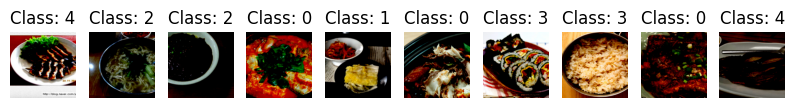

In [ ]:
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(np.transpose(X_train[i], (1, 2, 0)))
    plt.title('Class: ' + str(y_train[i].item()))

In [ ]:
import torchvision.models as models
model = models.resnet50(pretrained = True)
print(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 99.9MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
for parameter in model.parameters():
    parameter.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
            nn.Linear(num_ftrs, 5),
            nn.LogSoftmax(dim=1)
        )

model = model.to(DEVICE)

In [18]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [19]:
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

In [20]:
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE, dtype=torch.long)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image),
                len(train_loader.dataset), 100. * batch_idx / len(train_loader),
                loss.item()))
            scheduler.step()


In [21]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE, dtype=torch.long)
            output = model(image)
            test_loss += criterion(output, label).item()
            probabilities = F.softmax(output, dim=1)
            _, predicted = torch.max(probabilities, 1)
            correct += (predicted == label).sum().item()


    test_loss /= (len(test_loader.dataset) / BATCH_SIZE)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [22]:
for epoch in range(1, EPOCHS + 1):
    train(model, dataloaders["train"], optimizer, log_interval = 5)
    valid_loss, valid_accuracy = evaluate(model, dataloaders["val"])
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, valid_loss, valid_accuracy))

Train Epoch: 1 [0/3490 (0%)]	Train Loss: 0.381090
Train Epoch: 1 [160/3490 (5%)]	Train Loss: 0.670691
Train Epoch: 1 [320/3490 (9%)]	Train Loss: 0.815158
Train Epoch: 1 [480/3490 (14%)]	Train Loss: 0.434094
Train Epoch: 1 [640/3490 (18%)]	Train Loss: 0.994087
Train Epoch: 1 [800/3490 (23%)]	Train Loss: 0.736892
Train Epoch: 1 [960/3490 (27%)]	Train Loss: 0.598456
Train Epoch: 1 [1120/3490 (32%)]	Train Loss: 0.573985
Train Epoch: 1 [1280/3490 (36%)]	Train Loss: 0.792724
Train Epoch: 1 [1440/3490 (41%)]	Train Loss: 0.671684
Train Epoch: 1 [1600/3490 (45%)]	Train Loss: 0.298198
Train Epoch: 1 [1760/3490 (50%)]	Train Loss: 0.538421
Train Epoch: 1 [1920/3490 (55%)]	Train Loss: 0.540186
Train Epoch: 1 [2080/3490 (59%)]	Train Loss: 0.519029
Train Epoch: 1 [2240/3490 (64%)]	Train Loss: 0.656139
Train Epoch: 1 [2400/3490 (68%)]	Train Loss: 0.894138
Train Epoch: 1 [2560/3490 (73%)]	Train Loss: 0.710187
Train Epoch: 1 [2720/3490 (77%)]	Train Loss: 0.579454
Train Epoch: 1 [2880/3490 (82%)]	Train L